In [1]:
myrank=32

In [2]:
from transformers import AutoTokenizer, AdamW, get_scheduler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm.auto import tqdm
import loralib as lora
import mylora
import re
import time
from matplotlib import pyplot as plt 
%matplotlib inline

#data prepare and process
f = open("chinese.txt", "r")
cndata = f.readlines()
f.close()

f = open("english.txt", "r")
endata = f.readlines()
f.close()

assert len(cndata) == len(endata) == 252777

mydata = [{"cn": cn.strip(), "en": en.strip()} for cn, en in zip(cndata, endata)]

class Mydataset(Dataset):
    def __init__(self, mydata) -> None:
        super().__init__()
        self.data = mydata
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]

mydata = Mydataset(mydata)
train_size = int(0.8 * 252777)
val_size = 252777 - train_size
trainset, valset = random_split(mydata, lengths=[train_size, val_size])

model_checkpoint = "Helsinki-NLP/opus-mt-zh-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

max_input_length = 128
max_target_length = 128

e:\anaconda3\envs\myml\Lib\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [3]:
#model
from transformers import AutoModelForSeq2SeqLM
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, force_download=True, resume_download=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

#just a test
linear_weight = model.model.decoder.layers[0].fc1.weight

#add lora to the model
for name, module in model.named_modules():
    if ('self_attn' in name or 'self_attention' in name) and isinstance(module, nn.Linear):
        parent_name, child_name = name.rsplit('.', 1)
        parent_name = re.sub(r"\.(\d)", r"[\1]", parent_name)
        setattr(eval(f'model.{parent_name}'), child_name, mylora.VeRALinear(module.in_features, module.out_features, r=myrank))

#set the non-lora layer gradient to 0
lora.mark_only_lora_as_trainable(model)

#some check
assert model.model.decoder.layers[0].self_attn.k_proj.lora_b.requires_grad == True
assert model.model.decoder.layers[0].self_attn.k_proj.lora_d.requires_grad == True
assert model.model.decoder.layers[0].self_attn.k_proj.B.requires_grad == False
assert model.model.decoder.layers[0].self_attn.k_proj.A.requires_grad == False
assert model.model.decoder.layers[0].self_attn.k_proj.weight.requires_grad == False
assert model.model.decoder.layers[0].fc1.weight.requires_grad == False
linear_weight2 = model.model.decoder.layers[0].fc1.weight
assert torch.norm(linear_weight2 - linear_weight, p=2) < 1e-5

model = model.to(device)

cuda


In [4]:
def mycollate_fn(batch_samples):
    batch_inputs, batch_targets = [], []
    for sample in batch_samples:
        batch_inputs.append(sample['cn'])
        batch_targets.append(sample['en'])
    batch_data = tokenizer(
        batch_inputs,
        padding=True,
        max_length=max_input_length,
        truncation=True,
        return_tensors="pt"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch_targets,
            padding=True,
            max_length=max_target_length,
            truncation=True,
            return_tensors="pt"
        )["input_ids"]
        batch_data['decoder_input_ids'] = model.prepare_decoder_input_ids_from_labels(labels)
        end_token_index = torch.where(labels == tokenizer.eos_token_id)[1]
        for idx, end_idx in enumerate(end_token_index):
            labels[idx][end_idx+1:] = -100
        batch_data['labels'] = labels
    return batch_data

train_dataloader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=mycollate_fn)
valid_dataloader = DataLoader(valset, batch_size=32, shuffle=False, collate_fn=mycollate_fn)

In [5]:
#only optimize lora layers
optimizer = AdamW(filter(lambda p: p.requires_grad_, model.parameters()), lr=3e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
progress_bar.set_description(f'loss: {0:>7f}')

total_loss = 0.0
losses = []

i = 1
model.train()
for epoch in range(num_epochs):
    t1 = time.time()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        total_loss += loss.item()
        progress_bar.set_description(f'loss: {total_loss/i:>7f}')
        progress_bar.update(1)
        i += 1
    t2 = time.time()
    print("epoch {}, training time {}".format(i, t2-t1))

e:\anaconda3\envs\myml\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/6320 [00:00<?, ?it/s]

e:\anaconda3\envs\myml\Lib\site-packages\transformers\tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "zh_en_vera_fullmodel.pt")
torch.save(lora.lora_state_dict(model), "zh_en_vera_only.pt")

In [ ]:
preds, labels = [], []
import numpy as np
from sacrebleu.metrics import BLEU
bleu = BLEU()

model.eval()
for batch_data in tqdm(valid_dataloader):
    batch_data = batch_data.to(device)
    with torch.no_grad():
        generated_tokens = model.generate(
            batch_data["input_ids"],
            attention_mask=batch_data["attention_mask"],
            max_length=max_target_length,
        ).cpu().numpy()
    label_tokens = batch_data["labels"].cpu().numpy()

    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    label_tokens = np.where(label_tokens != -100, label_tokens, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(label_tokens, skip_special_tokens=True)

    preds += [pred.strip() for pred in decoded_preds]
    labels += [[label.strip()] for label in decoded_labels]
    print(preds[0])
    print(labels[0])
    break
bleu_score = bleu.corpus_score(preds, labels).score
print(f"BLEU: {bleu_score:>0.2f}\n")

  0%|          | 0/1580 [00:00<?, ?it/s]

However, however, however, however, however, and lack transparency, and lack transparency, as well.
['But the lack of transparency surrounding data surveillance and mining means that, when a whistleblower leaks information, everyone can subsequently use it to build their own version of how and why policy is made.']
BLEU: 6.46



In [ ]:
def translate_sentence(model, tokenizer, sentence, device, max_target_length=128):
    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=max_target_length)
    print(inputs)
    # Move tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate translation using the model
    with torch.no_grad():
        generated_tokens = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_target_length,
        ).cpu().numpy()

    # Decode the generated tokens to a string
    decoded_translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    return decoded_translation

# Example usage
model.eval() # Make sure the model is in evaluation mode
sentence = ["你好，世界", "你爱我我爱你，蜜雪冰城甜蜜蜜", "京都市是位于日本京都府南部的城市，为京都府府治，也是政令指定都市之一。", "翻译是一个能够突显注意力机制优势的例子，其中上下文对于句子中单词的含义至关重要。"] # Your Chinese sentence
translation = translate_sentence(model, tokenizer, sentence, device)
print(translation)

{'input_ids': tensor([[ 5349,     2,   907,     0, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000],
        [  132, 28609, 41412,     2, 16351,  9128,  8677,  5257, 47772, 16351,
             0, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000, 65000,
         65000, 65000, 65000, 65000, 65000, 65000],
        [    7, 22070, 30331,    69,  7001,  2049, 22070,   291, 19838,  7355,
         18682,     2,    74, 22070,   291, 19838, 19838,  8092,     2,  1956,
         37868,  3606, 30331,  2086,     9,     0],
        [    7,  7925,  1878,   577, 40382, 17460,   660, 12736, 12154,     2,
           716,   150, 12307,  1003, 10054,   863,    80,  3681,  5989, 20660,
          2977,     9,     0, 65000, 65000, 65000]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [1, 1, 1, 1, 1, 1, 1,

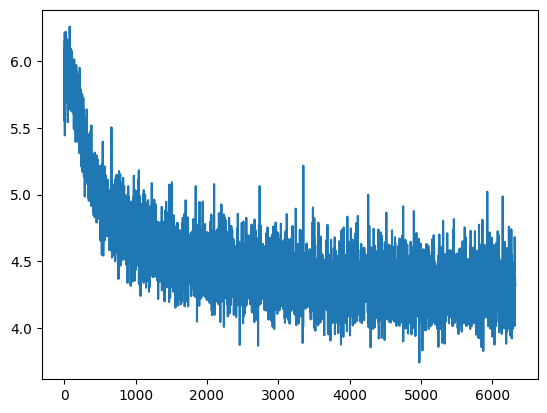

In [ ]:
plt.plot(list(range(len(losses))), losses)
plt.show()